In [1]:
import json
import glob
import json_lines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.svm import LinearSVC
import os
from nltk.corpus import stopwords
import string
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.naive_bayes import GaussianNB
import warnings
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import nltk

from nltk.tokenize import word_tokenize 
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
%pylab inline



Populating the interactive namespace from numpy and matplotlib


In [2]:
#Import the csv file
PolitifactData = pd.read_csv("C:/Users/Max/Desktop/PROJECT/DataSets/SnopesDataPrepMini.csv") 

Now must find useful features to determine fake from real news.

In [3]:
PolitifactData.head()

,Claim,Credibility,Description,GoogleResults
0,"Meijer is offering $100 off ""Back to School"" c...",0,feature slight typically redirect survey provi...,content walker coupon good retailer coupon fra...
1,"A photograph depicts a real (giant) pizza, par...",1,however linked image led coming soon message i...,content claim photograph real giant pizza part...
2,Image depicts a 102 lb. shrimp caught near Hom...,0,image man proudly posing giant prawn shrimp le...,content claim image shrimp caught near collect...
3,A 14-year-old girl became pregnant after recei...,0,typical pregnant woman first time young woman ...,content san old schoolgirl serious flu shot al...
4,NASA confirmed there will be 15 straight days ...,0,world remain complete darkness starting end ac...,domain link kan title domain link video spilt ...


Now im going to drop the labels and create a train and test dataset. I decided to use the Description because it has a short and clear description of the given claim which is based on the articles in the SearchResult. And since im going to use Bag-of-Words and TF-IDF I will hopefully be able to extrackt some destinctive words.


In [4]:
y = PolitifactData.Credibility

In [5]:
PolitifactData = PolitifactData.drop('Credibility', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(PolitifactData['Description'], y, test_size=0.3, random_state=53)

## Building Vectorizer Classifiers

We are doing this to see wheather the words and tokens in the article had a segnificant impact in clasifieng an stetement to fake or true.

See documentation [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).
Changing the max_df and  min_df of the TF-IDF vectorizer can have an impact on the final result

It is also possible to use other vectorizers for text classification like `HashingVectorizer`. `HashingVectorizer` requires less memmory than tdf-idf and count vectorizers and are faster becouse they are sparse and use hashes rather than tokens.
[`HashingVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)

In [7]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [9]:
hash_vectorizer = HashingVectorizer(stop_words='english', non_negative=True)
hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)

There is clearly a lot of noise in the vecors, this can be removed with some more enhanced text preprocessing

In [10]:
tfidf_vectorizer.get_feature_names()[:50]

['aal',
 'aam',
 'aardvark',
 'aba',
 'abac',
 'aback',
 'abandon',
 'abandoned',
 'abandonment',
 'abashedly',
 'abatement',
 'abattoir',
 'abb',
 'abbas',
 'abbasi',
 'abbey',
 'abbot',
 'abbreviation',
 'abdicate',
 'abdication',
 'abdomen',
 'abdominal',
 'abduct',
 'abduction',
 'abductor',
 'abeam',
 'abed',
 'aberrant',
 'aberration',
 'abet',
 'abhorrence',
 'abhorrent',
 'abide',
 'abiding',
 'abigail',
 'ability',
 'abject',
 'abjectly',
 'ablaze',
 'able',
 'ablest',
 'ably',
 'abnormal',
 'abnormality',
 'abnormally',
 'aboard',
 'abode',
 'abolish',
 'abolishment',
 'abolition']

## Evaluating Models

I used confusion matrices to visualize and compare models. Another method to visualize which I might implement is [ROC Curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html). Check out [scikit-learn metrics module](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) for other ways to evaluete the models.

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# MODELS

I will compare the following models :

- multinomialNB with counts (`sgd_count_clf`)
- multinomialNB with tf-idf (`mn_tfidf_clf`)
- passive aggressive with tf-idf (`pa_tfidf_clf`)
- linear svc with tf-idf (`svc_tfidf_clf`)
- linear sgd with tf-idf (`sgd_tfidf_clf`)

### MultinomialNB with TF-IDF

In this part I am going to train and test the trained models using sklearn package. And first I will start with `MultinomialNB`. I use it to compare TF-IDF versus bag-of-words. I noticed that `CountVectorizer` performed better in this model. This is becouse multinomial distribution works better with integers. Check out [this](https://onlinecourses.science.psu.edu/stat504/node/40) for an explanation why.

accuracy:   0.740
Confusion matrix, without normalization


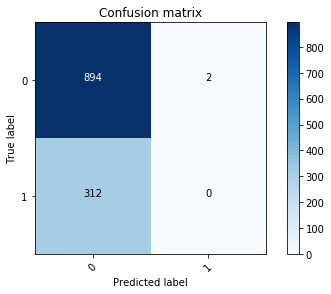

In [12]:
MNB_tfidf = MultinomialNB() 
MNB_tfidf.fit(tfidf_train, y_train)
pred = MNB_tfidf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### TFIDF with tuning alpha value
Lets do some parametr tuning on the `alpha` value for a MultinomialNB. I also want to implement [parameter tuning with grid search](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#parameter-tuning-using-grid-search) for a more exhaustive search.

In [13]:
MNB_tfidf_alpha = MultinomialNB(alpha=0.1)
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        MNB_tfidf_alpha = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.74255
Alpha: 0.10 Score: 0.75993
Alpha: 0.20 Score: 0.75331
Alpha: 0.30 Score: 0.74338
Alpha: 0.40 Score: 0.74089
Alpha: 0.50 Score: 0.74089
Alpha: 0.60 Score: 0.74089
Alpha: 0.70 Score: 0.74007
Alpha: 0.80 Score: 0.74007
Alpha: 0.90 Score: 0.74007


### MultinomialNB with TF-IDF

accuracy:   0.760
Confusion matrix, without normalization


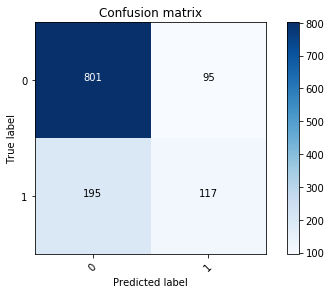

In [14]:
MNB_count = MultinomialNB() 
MNB_count.fit(count_train, y_train)
pred = MNB_count.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### MultinomialNB with Hash

accuracy:   0.743
Confusion matrix, without normalization


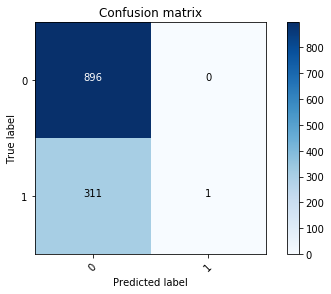

In [15]:
MNB_hash = MultinomialNB(alpha=.01)
MNB_hash.fit(hash_train, y_train)
pred = MNB_hash.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

## Linear Models

Liniar models perform well with TF-IDF vectorizers. Here are some sources [word2vec for classification](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/), [SVM reference in scikit-learn text analysis](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set)

I also tried to compare Passive Aggressive classifiers to linear SVMs for text classification.   [Lecture]( https://www.youtube.com/watch?v=4LINLfsq1yE&list=PLBv09BD7ez_4XyTO5MnDLV9N-s6kgXQy7) 


### Passive Aggressive clasifier with TF-IDF

accuracy:   0.793
Confusion matrix, without normalization


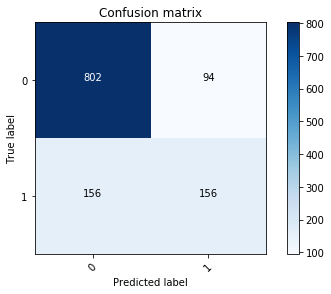

In [16]:
pa_tfidf = PassiveAggressiveClassifier(n_iter=50)
pa_tfidf.fit(tfidf_train, y_train)
pred = pa_tfidf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### Linear SVC wiht TFIDF

accuracy:   0.796
Confusion matrix, without normalization


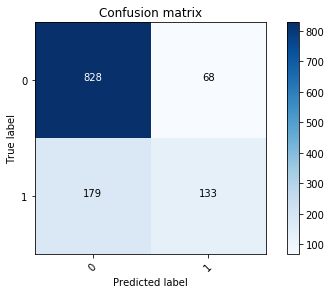

In [17]:
svc_tfidf = LinearSVC()
svc_tfidf.fit(tfidf_train, y_train)
pred = svc_tfidf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### Linear SVC with Count

accuracy:   0.768
Confusion matrix, without normalization


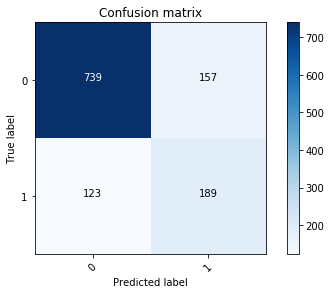

In [18]:
svc_count = LinearSVC()
svc_count.fit(count_train, y_train)
pred = svc_count.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### Linear SVC with Hash

accuracy:   0.799
Confusion matrix, without normalization


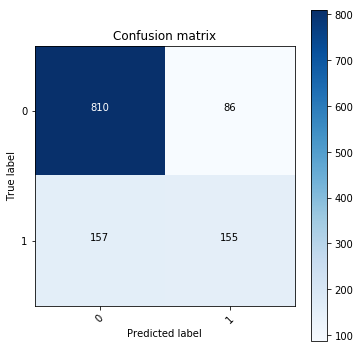

In [19]:
svc_hash = LinearSVC()
plt.rcParams["figure.figsize"] = (5,5)
svc_hash.fit(hash_train, y_train)
pred = svc_hash.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### Linear SGD with TD-IDF

accuracy:   0.783
Confusion matrix, without normalization


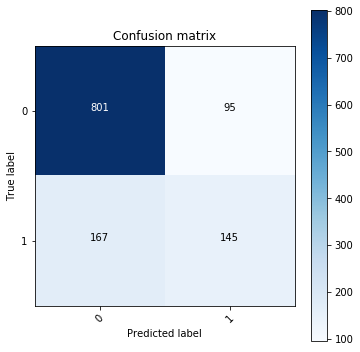

In [20]:
sgd_tfidf = SGDClassifier()
sgd_tfidf.fit(tfidf_train, y_train)
pred = sgd_tfidf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

### ROC Curve

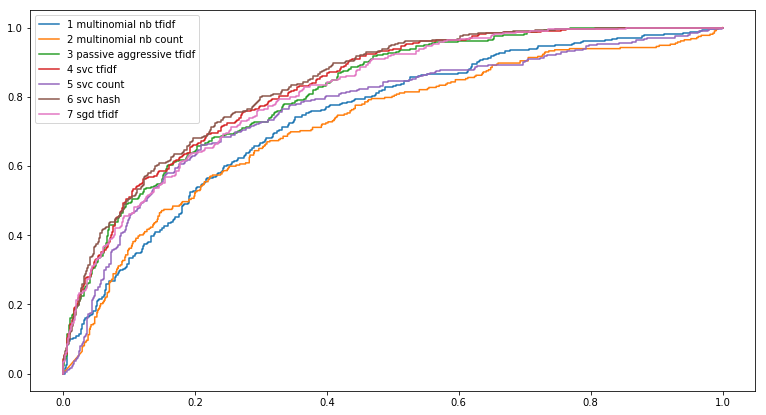

In [21]:
plt.rcParams["figure.figsize"] = (13,7)
plt.figure(0).clf()
#save
for model, name in [ (MNB_tfidf, '1 multinomial nb tfidf'),
                     (MNB_count, '2 multinomial nb count'),
                     (pa_tfidf, '3 passive aggressive tfidf'),
                     (svc_tfidf, '4 svc tfidf'),
                     (svc_count, '5 svc count'),
                     (svc_hash, '6 svc hash'),
                     (sgd_tfidf, '7 sgd tfidf')]:
    if '2' in name:
        pred = model.predict_proba(count_test)[:,1]
    elif '1' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    elif '5' in name:
        pred = model.decision_function(count_test)
    elif '6' in name:
        pred = model.decision_function(hash_test)
        
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred, pos_label=1)
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)

### Introspecting models

Using a function from [this](https://stackoverflow.com/a/26980472)  writ-up im am going to inspect which vectors affect the labels the most. 

I am going to inspect the top 30 vectors for the best performing clasifier `Liniar SVC` with count vector dataset `count_vectorizer`



In [22]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return {class_labels[0]: topn_class1,class_labels[1]: topn_class2}

Here I want to demonstrate the most significant features learned by a clasifier

In [23]:
most_informative_feature_for_binary_classification(count_vectorizer, svc_count, n=8)

{0: [(-0.6405895755507257, 'mint'),
  (-0.5802348230585671, 'quarter'),
  (-0.5647111268545486, 'supportive'),
  (-0.48595591317971815, 'vehicular'),
  (-0.44393377480685375, 'manslaughter'),
  (-0.4086330162657545, 'rumor'),
  (-0.36314027217892025, 'fake'),
  (-0.354492528481826, 'satirical')],
 1: [(0.34390484041484454, 'endorsement'),
  (0.38058543909034437, 'coverage'),
  (0.38465513992973976, 'additional'),
  (0.42333127133326015, 'marital'),
  (0.4399213354887584, 'smile'),
  (0.44953021098771234, 'recent'),
  (0.5148917447638748, 'chairman'),
  (0.5409455545294579, 'tacit')]}

In [24]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, svc_count, n=8)

{0: [(-0.6405895755507257, 'mint'),
  (-0.5802348230585671, 'quarter'),
  (-0.5647111268545486, 'supportive'),
  (-0.48595591317971815, 'vehicular'),
  (-0.44393377480685375, 'manslaughter'),
  (-0.4086330162657545, 'rumor'),
  (-0.36314027217892025, 'fake'),
  (-0.354492528481826, 'satirical')],
 1: [(0.34390484041484454, 'endorsement'),
  (0.38058543909034437, 'coverage'),
  (0.38465513992973976, 'additional'),
  (0.42333127133326015, 'marital'),
  (0.4399213354887584, 'smile'),
  (0.44953021098771234, 'recent'),
  (0.5148917447638748, 'chairman'),
  (0.5409455545294579, 'tacit')]}

In [ ]:
def BagOfWords(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [ ]:
#Creating lists of words
x = BagOfWords(PolitifactData['Description'])
y = PolitifactData.Credibility

In [ ]:
vector_dimension = 300

In [ ]:
text_model = Doc2Vec(min_count=1, window=5, vector_size = vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10, seed=1)
text_model.build_vocab(x)
text_model.train(x, total_examples = text_model.corpus_count, epochs=text_model.iter)

In [ ]:
train_size = int(0.8 * len(x))
test_size = len(x) - train_size

In [ ]:
text_train_arrays = np.zeros((train_size, vector_dimension))
text_test_arrays = np.zeros((test_size, vector_dimension))
train_labels = np.zeros(train_size)
test_labels = np.zeros(test_size)

In [ ]:
for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
    train_labels[i] = y[i]

In [ ]:
j = 0
for i in range(train_size:train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
    test_labels[j] = y[i]
    j = j + 1

Building the model

In [ ]:
np.save('./text_train_arrays', text_train_arrays)
np.save('./text_test_arrays', text_test_arrays)
np.save('./train_labels', train_labels)
np.save('./test_labels', test_labels)

In [ ]:
xtr = np.load('./text_train_arrays.npy')
xte = np.load('./text_test_arrays.npy')
ytr = np.load('./train_labels.npy')
yte = np.load('./test_labels.npy')

In [ ]:
# Use the built-in Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.94%

In [ ]:
# Draw the confusion matrix

skplt.plot_confusion_matrix(yte,y_pred)
plt.show()